# Cranes at CVR – Final Project
## Analyzing Micro-Expressions for Lie Detection using Computer Vision (Truth or Lie)
------------------------------------------------------------------------------------------------------------------------------------------------------
### Project Question:
Can computer vision techniques be employed to analyze micro-expressions in facial images to effectively distinguish between truthful and deceptive behaviors, utilizing the provided dataset?

------------------------------------------------------------------------------------------------------------------------------------------------------
### Dataset:
Dataset link: https://www.kaggle.com/datasets/devvratmathur/micro-expression-dataset-for-lie-detection

Git Hub Reprository link: https://github.com/Pritanshu5000/micro-expression-lie-detection.git

------------------------------------------------------------------------------------------------------------------------------------------------------
### Project Workflow:
1. Dataset Exploration and Understanding:
- Download and extract the dataset.
- Examine the folder structure and file formats.
- Understand the labeling of truthful and deceptive expressions.
2. Data Preprocessing:
- Convert video clips to frame sequences if necessary.
- Normalize and resize images for consistency.
- Augment data to address class imbalance.
3. Feature Extraction:
- Apply facial landmark detection to identify key facial regions.
- Extract temporal features capturing micro-expression dynamics.
- Consider using optical flow to capture subtle movements.
4. Model Development:
- Design a CNN or RNN model suitable for temporal data.
- Train the model on the preprocessed dataset.
- Validate the model using appropriate metrics.
5. Evaluation:
- Assess model performance using accuracy, precision, recall, and F1-score.
- Analyze confusion matrix to understand misclassifications.
- Compare results with baseline models or previous studies.
6. Conclusion and Reporting:
- Summarize findings and model effectiveness.
- Discuss potential applications in security and psychology.
- Highlight limitations and propose future work.
-------------------------------------------------------------------------------------------------------------------------------------------------------
### Submission Instructions:
- Upload the Jupyter Notebook and trained model file to a public GitHub repository.
- Include a README.md detailing project overview and execution steps.
- Add the GitHub repository link to the final report (report.md or report.pdf).
- Submit a ZIP file containing the complete project folder, including notebooks, models, and reports.

------------------------------------------------------------------------------------------------------------------------------------------------------

### PIP Install all Necessary Python Libraries

In [2]:
%pip install numpy
%pip install tensorflow
%pip install matplotlib
%pip install opencv-python
%pip install pandas
%pip install pillow
%pip install visualkeras
%pip install keras-tuner
%pip install scikit-learn
%pip install seaborn
%pip install streamlit
%pip install mediapipe
%pip install imgaug
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

------------------------------------------------------------------------------------------------------------------------------------------------------
### Import Python tools and libraries

In [4]:
import os
import cv2
import glob
import random
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import visualkeras as vk
import tensorflow as tf

from PIL import Image
from tqdm import tqdm
from xgboost import XGBClassifier
from keras.saving import save_model
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

------------------------------------------------------------------------------------------------------------------------------------------------------
### Step 1: Dataset Exploration and Understanding:

In [6]:
# Download and extract the dataset:
''' * Visit the Kaggle dataset link: https://www.kaggle.com/datasets/devvratmathur/micro-expression-dataset-for-lie-detection
    * Click 'Download' -> 'Download dataset as zip'
    * Extract the zip file into your project directory. '''

# Set dataset path
proj_dir = r'micro-expression-dataset-for-lie-detection'

img_files = glob.glob(proj_dir + "/**/*.[jp][pn]g", recursive=True)  

print(f"Total images found within the whole dataset: {len(img_files)}")

Total images found within the whole dataset: 23473


In [8]:
# Examine the folder structure and file formats:

# Function to explore folder structure
def explore_dataset(path):
    print(f"Exploring: {path}")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files[:3]:  # Limit to showing first 3 files per folder
            print(f"{sub_indent}{f}")
        if level > 7:
            break  # Prevent too deep exploration for readability

explore_dataset(proj_dir)

Exploring: micro-expression-dataset-for-lie-detection
micro-expression-dataset-for-lie-detection/
    Demo.png
    Directory.docx
    README File.txt
    Metadata/
        Metadata/
            Atul.xlsx
            Dishant.xlsx
            DrPrashant.xlsx
    Test/
        Test/
            Lie/
                Atul/
                    What is your Name/
                        Atul10400.png
                        Atul10401.png
                        Atul10402.png
                    What is your Profession/
                        Atul11225.png
                        Atul11226.png
                        Atul11227.png
                Dishant/
                    What is your Name/
                        Dishant08780.png
                        Dishant08781.png
                        Dishant08782.png
                    What is your Profession/
                        Dishant09090.png
                        Dishant09091.png
                        Dishant09092.png
             

In [10]:
# Understand the labeling of truthful and deceptive expressions:

# Read metadata file for 'Atul'
metadata_file = os.path.join(proj_dir, "Metadata", "Metadata", "Atul.xlsx")

if os.path.exists(metadata_file):
    df = pd.read_excel(metadata_file)
    print(f"Metadata File: {metadata_file}")
    display(df.head())  # Using display() for better rendering in Jupyter
    display(df.tail())
else:
    print("Metadata file not found.")

Metadata File: micro-expression-dataset-for-lie-detection\Metadata\Metadata\Atul.xlsx


Question  Label  \
0              What is your Name ?  Truth   
1        What is your Profession ?  Truth   
2             What is your Hobby ?  Truth   
3    What is your Favourite Food ?  Truth   
4  What is your Favourite Colour ?  Truth   

                                              Answer  Start Frame  End Frame  
0                                 मेरा नाम Atul है ।        380.0      500.0  
1  मैं MSC math का student हूँ, मैं NIT Jalandhar...       1630.0     2005.0  
2  मेरी hobby travelling, bike riding, और book re...       2440.0     3085.0  
3  गुलाब जामुन और, और chicken, chicken Favourite ...       4760.0     5450.0  
4                     Favourite color i think white.       5790.0     6030.0

Question Label  \
10                               What is your Hobby ?   Lie   
11                      What is your Favourite Food ?   Lie   
12                    What is your Favourite Colour ?   Lie   
13  Who is your Favourite Bollywood actor &  actre...   Lie   
14            You are a Morning person or Night Owl ?   Lie   

                                 Answer  Start Frame  End Frame  
10  मेरी hobby dance करना singing करना।      11870.0    12060.0  
11                     आह करेला, कद्दू।      12600.0    12860.0  
12                       लाल,हरा, पीला।      13130.0    13420.0  
13                                  NaN          NaN        NaN  
14                  मैं Night Owl हूँ ।      12240.0    12330.0

In [12]:
MAX_TRAIN_SAMPLES = 200

ALL_PARTICIPANTS = [
    "Atul", "Dishant", "DrPrashant", "Harsha", "Mansi", "Mansvi", "Sailja", "Siddhi"
]

MEN = ["Atul", "Dishant", "DrPrashant"]
WOMEN = ["Harsha", "Mansi", "Mansvi", "Sailja", "Siddhi"]

random.seed(42)
held_out_male = "Atul"
held_out_female = "Harsha"
TEST_PARTICIPANTS = [held_out_male, held_out_female]
TRAIN_PARTICIPANTS = [p for p in ALL_PARTICIPANTS if p not in TEST_PARTICIPANTS]

print("Test participants:", TEST_PARTICIPANTS)
print("Train participants:", TRAIN_PARTICIPANTS)

TRAIN_QUESTIONS = [
    "What is your Favorite Color",
    "What is your Favorite Food",
    "What is your Hobby",
    "You are a Morning person or Night Owl",
    "What is your Name",
    "What is your Profession"
]
TEST_QUESTIONS = [
    "What is your Name",
    "What is your Profession"
]

Test participants: ['Atul', 'Harsha']
Train participants: ['Dishant', 'DrPrashant', 'Mansi', 'Mansvi', 'Sailja', 'Siddhi']


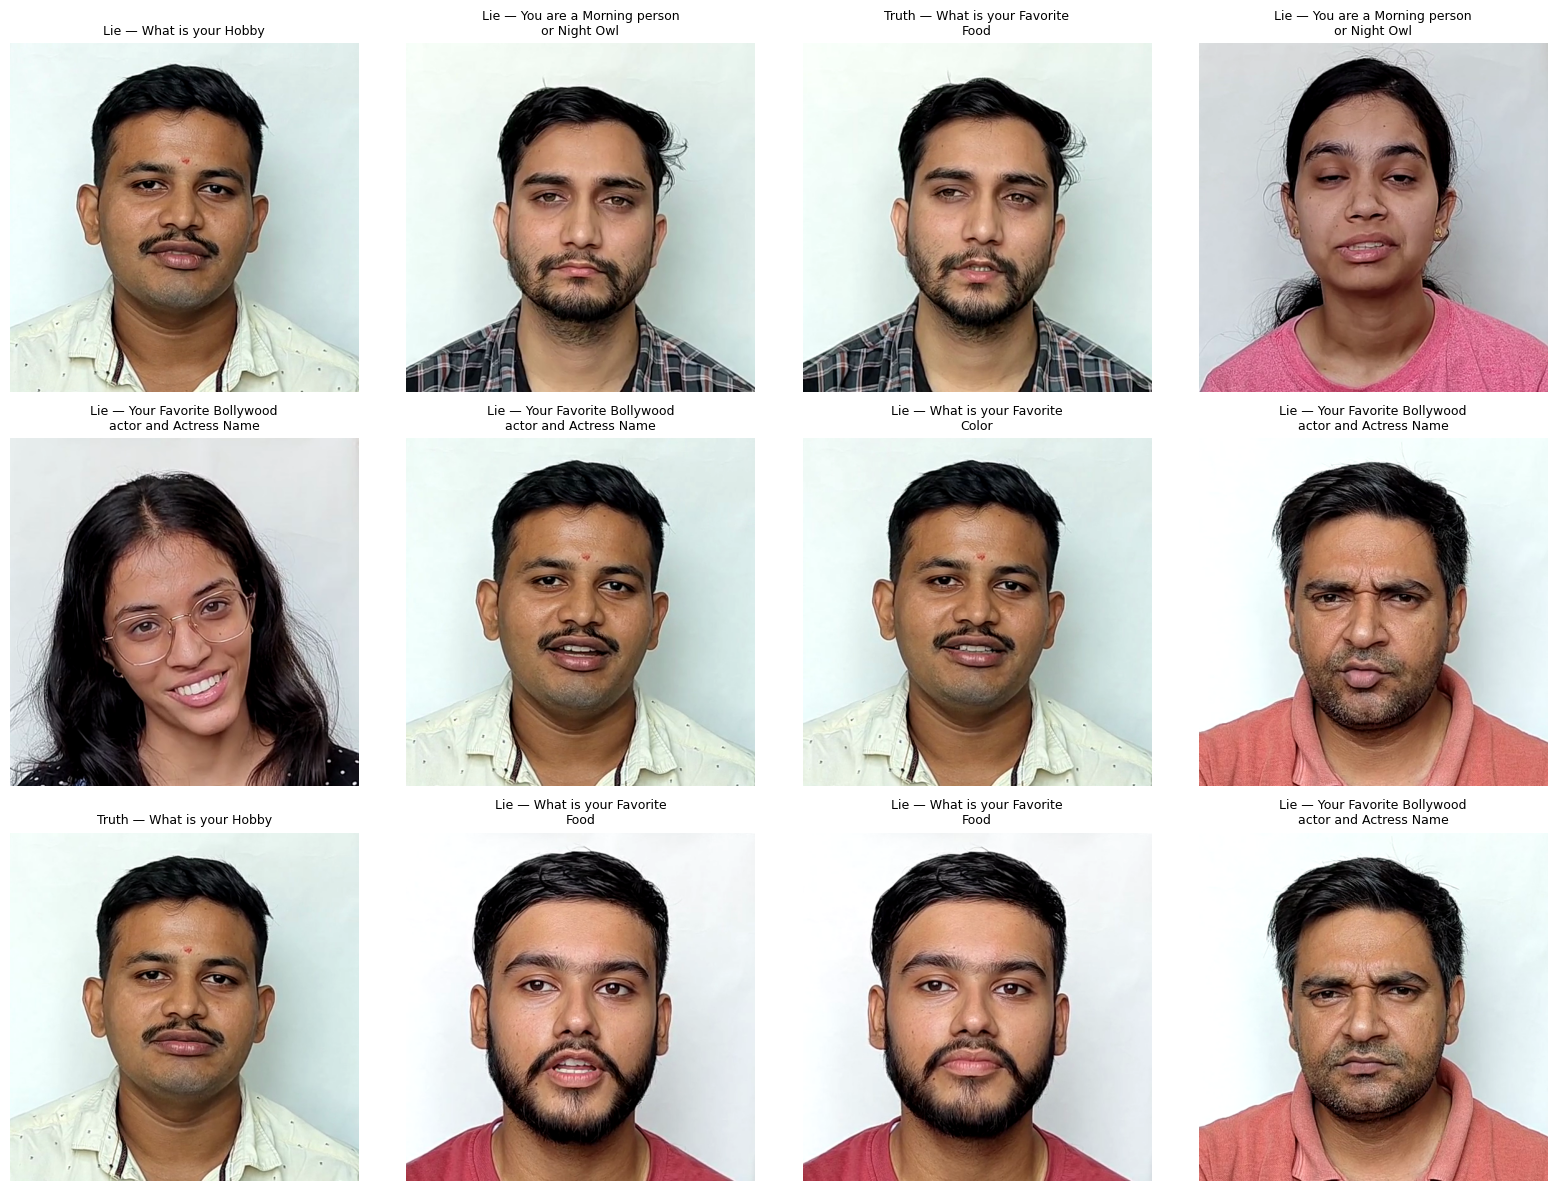

In [14]:
# Path to the dataset
dataset_path = os.path.join(proj_dir, "Train", "Train")

# Collect image paths with labels and questions
image_data = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            parts = os.path.normpath(full_path).split(os.sep)

            try:
                # Expecting: .../Train/Lie/Dishant/What is your Name/image.png
                label = parts[-4]       # Lie or Truth
                question = parts[-2]    # Question folder name
                image_data.append((full_path, label, question))
            except IndexError:
                print(f"⚠️ Skipping: {full_path} — unexpected folder structure")

# Randomly sample images
num_to_display = 12
if len(image_data) == 0:
    print("No valid images found.")
else:
    selected = random.sample(image_data, min(num_to_display, len(image_data)))

    cols = 4
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, (img_path, label, question) in enumerate(selected):
        img = Image.open(img_path).convert("RGB")
        title = f"{label} — {question}"
        title_wrapped = textwrap.fill(title, width=30)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title_wrapped, fontsize=9)

    plt.tight_layout()
    plt.show()

In [16]:
# Code to Collect Image Paths + Labels

from glob import glob

image_paths = []
labels = []

base_dir = os.path.join(proj_dir, "Train", "Train")  # or Test/ or your combined folder

# Traverse 'Truth' and 'Lie' folders
for label_name in os.listdir(base_dir):
    label_folder = os.path.join(base_dir, label_name)

    if os.path.isdir(label_folder):
        # Recursively find all PNG images under this label
        for img_path in glob(os.path.join(label_folder, "**", "*.png"), recursive=True):
            image_paths.append(img_path)
            labels.append(label_name.lower())  # Ensure lowercase: 'truth' or 'lie'
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

# Preview Images
print(f"Total images found: {len(image_paths)}")
print(f"Sample: {image_paths[0]}")
print(f"Corresponding label: {labels[0]}")

# Encode the Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Total images found: 17634
Sample: micro-expression-dataset-for-lie-detection\Train\Train\Lie\Atul\What is your Favorite Color\Atul13130.png
Corresponding label: lie


------------------------------------------------------------------------------------------------------------------------------------------------------
### Step 2: Data Preprocessing:

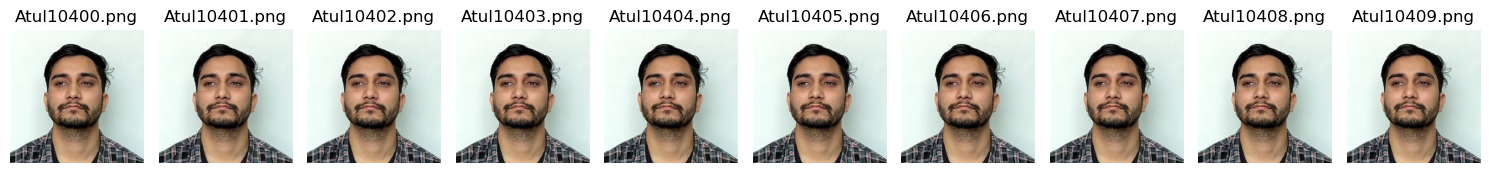

In [18]:
# Convert video clips to frame sequences (Already done — dataset provides images).

# Sample path (can change to Truth, Lie, other person, etc.)
sample_img_dir = os.path.join(proj_dir, "Test", "Test", "Lie", "Atul", "What is your Name")
sample_imgs = sorted([img for img in os.listdir(sample_img_dir) if img.endswith(".png")])[:10]

# Display sample frames
plt.figure(figsize=(15, 3))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(sample_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Normalize and resize images for consistency:

# Image size (resize for model)
IMG_SIZE = (64, 64)

# Define Function to Load Images
def load_images_from_folder(folder_path, label):
    data = []
    labels = []
    
    for person in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person)
        if not os.path.isdir(person_path):
            continue
        for question in os.listdir(person_path):
            q_path = os.path.join(person_path, question)
            if not os.path.isdir(q_path):
                continue
            for image_file in os.listdir(q_path):
                if image_file.endswith(".png"):
                    img_path = os.path.join(q_path, image_file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, IMG_SIZE)
                    img = img.astype(np.float32) / 255.0  # Normalize
                    data.append(img)
                    labels.append(label)
    
    return np.array(data), np.array(labels)

# Load Data from Truth and Lie Folders
train_truth_path = os.path.join(proj_dir, "Train", "Train", "Truth")
train_lie_path = os.path.join(proj_dir, "Train", "Train", "Lie")
test_truth_path = os.path.join(proj_dir, "Test", "Test", "Truth")
test_lie_path = os.path.join(proj_dir, "Test", "Test", "Lie")

# Load data from all 4 folders
truth_data_train, truth_labels_train = load_images_from_folder(train_truth_path, 0)
lie_data_train, lie_labels_train = load_images_from_folder(train_lie_path, 1)
truth_data_test, truth_labels_test = load_images_from_folder(test_truth_path, 0)
lie_data_test, lie_labels_test = load_images_from_folder(test_lie_path, 1)

# Combine data
X = np.concatenate((truth_data_train, lie_data_train, truth_data_test, lie_data_test), axis=0)
y = np.concatenate((truth_labels_train, lie_labels_train, truth_labels_test, lie_labels_test), axis=0)

print(f"Total Combined Samples: {X.shape[0]}")
print(f"Class Distribution: {np.bincount(y)}")

Total Combined Samples: 23472
Class Distribution: [12298 11174]


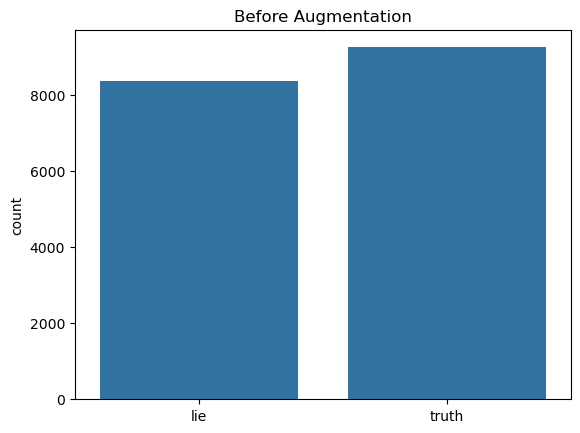

In [24]:
sns.countplot(x=labels)
plt.title("Before Augmentation")
plt.show()

Augmenting in batches: 100%|██████████| 23/23 [00:05<00:00,  3.99it/s]


Augmented dataset: (34646, 64, 64, 3) (34646,)


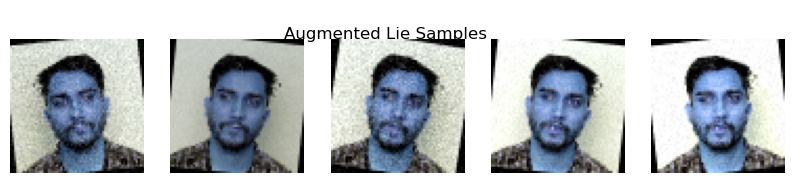

In [26]:
# Augment data to address class imbalance:

# Define sequence of augmentations
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),                    # Horizontal flip (50% chance)
    iaa.Affine(rotate=(-10, 10)),       # Random rotation
    iaa.GaussianBlur(sigma=(0, 1.0)),   # Slight blur
    iaa.Multiply((0.8, 1.2)),           # Brightness variation
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Noise
])

# Apply Augmentation to Minority Class [If you have a class imbalance (e.g., fewer “Lie” samples), we can augment only those]

def augment_in_batches(images, batch_size=500):
    augmented = []
    for i in tqdm(range(0, len(images), batch_size), desc="Augmenting in batches"):
        batch = images[i:i+batch_size]

        # Convert batch to uint8 (imgaug requires this)
        batch = (batch * 255).astype(np.uint8) if batch.dtype != np.uint8 else batch

        aug_batch = augmenter(images=batch)
        augmented.extend(aug_batch)
    return np.array(augmented, dtype=np.uint8)
    
# Find minority class (Lie indices)
lie_indices = np.where(y == 1)[0]
lie_images = X[lie_indices]

# Augment in smaller batches
augmented_lie_images = augment_in_batches(lie_images, batch_size=500)

# Stack augmented data (Combine original and augmented data)
X_aug = np.concatenate([X, augmented_lie_images], axis=0)
y_aug = np.concatenate([y, np.ones(len(augmented_lie_images))], axis=0)

print("Augmented dataset:", X_aug.shape, y_aug.shape)

# Visualize Augmented Samples
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_lie_images[i])
    plt.axis('off')
plt.suptitle("\nAugmented Lie Samples")
plt.show()

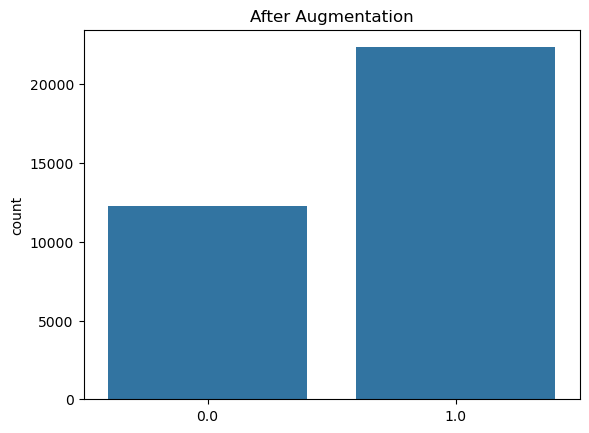

In [28]:
sns.countplot(x=y_aug)
plt.title("After Augmentation")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------
### Step 3: Feature Extraction:

In [30]:
# Apply facial landmark detection to identify key facial regions:
# Facial Landmark Detection using MediaPipe

# Initialize face mesh detector
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def extract_landmarks(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(img_rgb)

    if result.multi_face_landmarks:
        # Get landmark coordinates
        landmarks = result.multi_face_landmarks[0].landmark
        coords = np.array([[lm.x, lm.y, lm.z] for lm in landmarks]).flatten()
        return coords
    else:
        return None

In [32]:
# Extract temporal features capturing micro-expression dynamics

# Extract Temporal Dynamics per Sequence
def extract_temporal_features_from_sequence(folder_path, label):
    features = []
    labels = []

    for person in tqdm(os.listdir(folder_path)):
        person_path = os.path.join(folder_path, person)
        if not os.path.isdir(person_path): continue

        for question in os.listdir(person_path):
            q_path = os.path.join(person_path, question)
            if not os.path.isdir(q_path): continue

            sequence_landmarks = []
            for img_file in sorted(os.listdir(q_path)):
                if img_file.endswith(".png"):
                    img_path = os.path.join(q_path, img_file)
                    img = cv2.imread(img_path)
                    lm = extract_landmarks(img)
                    if lm is not None:
                        sequence_landmarks.append(lm)

            # Compute deltas between consecutive frames
            if len(sequence_landmarks) >= 2:
                deltas = np.diff(sequence_landmarks, axis=0)  # shape: (n-1, 1404)
                mean_delta = np.mean(deltas, axis=0)
                std_delta = np.std(deltas, axis=0)
                temporal_feature = np.concatenate([mean_delta, std_delta])
                features.append(temporal_feature)
                labels.append(label)

    return np.array(features), np.array(labels)

# Extract Temporal Features for Both Classes
# Define Paths
train_truth_path = os.path.join(proj_dir, "Train", "Train", "Truth")
train_lie_path   = os.path.join(proj_dir, "Train", "Train", "Lie")
test_truth_path  = os.path.join(proj_dir, "Test", "Test", "Truth")
test_lie_path    = os.path.join(proj_dir, "Test", "Test", "Lie")

# Extract Temporal Features for Each Class from Train and Test
truth_temp_train, truth_lbl_train = extract_temporal_features_from_sequence(train_truth_path, label=0)
lie_temp_train, lie_lbl_train = extract_temporal_features_from_sequence(train_lie_path, label=1)
truth_temp_test, truth_lbl_test = extract_temporal_features_from_sequence(test_truth_path, label=0)
lie_temp_test, lie_lbl_test = extract_temporal_features_from_sequence(test_lie_path, label=1)

# Combine all Temporal Features and Labels
X_temporal = np.concatenate((truth_temp_train, lie_temp_train, truth_temp_test, lie_temp_test), axis=0)
y_temporal = np.concatenate((truth_lbl_train, lie_lbl_train, truth_lbl_test, lie_lbl_test), axis=0)

print(f"Temporal Feature Shape: {X_temporal.shape}")
print(f"Label Distribution: {np.bincount(y_temporal)}")

100%|██████████| 7/7 [00:28<00:00,  4.09s/it]

Temporal Feature Shape: (96, 2808)
Label Distribution: [48 48]


In [34]:
# Consider using optical flow to capture subtle movements:

# Function to Optical Flow Feature Extraction per Sequence
def extract_optical_flow_features(sequence_path, label):
    features = []
    labels = []

    for person in tqdm(os.listdir(sequence_path)):
        person_dir = os.path.join(sequence_path, person)
        if not os.path.isdir(person_dir): continue

        for question in os.listdir(person_dir):
            q_path = os.path.join(person_dir, question)
            if not os.path.isdir(q_path): continue

            # Load sorted images
            frame_files = sorted([
                os.path.join(q_path, f) for f in os.listdir(q_path) if f.endswith(".png")
            ])

            if len(frame_files) < 2:
                continue  # skip if only 1 frame

            flow_magnitudes = []
            flow_angles = []

            for i in range(len(frame_files) - 1):
                img1 = cv2.imread(frame_files[i])
                img2 = cv2.imread(frame_files[i + 1])

                gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
                gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

                flow = cv2.calcOpticalFlowFarneback(
                    gray1, gray2,
                    None,
                    pyr_scale=0.5,
                    levels=3,
                    winsize=15,
                    iterations=3,
                    poly_n=5,
                    poly_sigma=1.2,
                    flags=0
                )

                mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
                flow_magnitudes.append(np.mean(mag))
                flow_angles.append(np.mean(ang))

            # Aggregate: mean and std of magnitudes and angles
            mag_mean = np.mean(flow_magnitudes)
            mag_std = np.std(flow_magnitudes)
            ang_mean = np.mean(flow_angles)
            ang_std = np.std(flow_angles)

            feature_vec = np.array([mag_mean, mag_std, ang_mean, ang_std])
            features.append(feature_vec)
            labels.append(label)

    return np.array(features), np.array(labels)

# Extract for Both Classes
# Define Paths for Train and Test Sets
train_truth_path = os.path.join(proj_dir, "Train", "Train", "Truth")
train_lie_path   = os.path.join(proj_dir, "Train", "Train", "Lie")
test_truth_path  = os.path.join(proj_dir, "Test", "Test", "Truth")
test_lie_path    = os.path.join(proj_dir, "Test", "Test", "Lie")

# Extract Optical Flow Features from Each Folder
truth_flow_train, truth_lbl_train = extract_optical_flow_features(train_truth_path, label=0)
lie_flow_train,   lie_lbl_train   = extract_optical_flow_features(train_lie_path, label=1)
truth_flow_test,  truth_lbl_test  = extract_optical_flow_features(test_truth_path, label=0)
lie_flow_test,    lie_lbl_test    = extract_optical_flow_features(test_lie_path, label=1)

# Combine All Optical Flow Features and Labels
X_flow = np.concatenate((truth_flow_train, lie_flow_train, truth_flow_test, lie_flow_test), axis=0)
y_flow = np.concatenate((truth_lbl_train, lie_lbl_train, truth_lbl_test, lie_lbl_test), axis=0)

print(f"Optical Flow Feature Shape: {X_flow.shape}")
print(f"Label Distribution: {np.bincount(y_flow)}")

100%|██████████| 7/7 [03:05<00:00, 26.49s/it]

Optical Flow Feature Shape: (96, 4)
Label Distribution: [48 48]


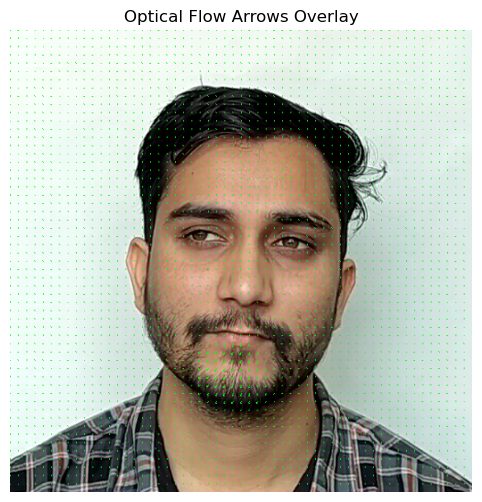

In [36]:
# Function to Draw Optical Flow Arrows
def draw_optical_flow_arrows(img1, img2, step=10):
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute optical flow
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )

    # Draw arrows
    h, w = gray1.shape
    flow_img = img1.copy()
    for y in range(0, h, step):
        for x in range(0, w, step):
            dx, dy = flow[y, x]
            end_point = (int(x + dx), int(y + dy))
            cv2.arrowedLine(flow_img, (x, y), end_point, (0, 255, 0), 1, tipLength=0.3)

    return flow_img

# Plotting Sample Output
def show_optical_flow_example(sequence_path):
    # Pick first 2 frames from a sample sequence
    frame_files = sorted([
        os.path.join(sequence_path, f)
        for f in os.listdir(sequence_path) if f.endswith(".png")
    ])
    
    if len(frame_files) < 2:
        print("Need at least 2 frames.")
        return

    img1 = cv2.imread(frame_files[0])
    img2 = cv2.imread(frame_files[1])

    flow_img = draw_optical_flow_arrows(img1, img2)

    # Convert to RGB for matplotlib
    flow_img_rgb = cv2.cvtColor(flow_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(flow_img_rgb)
    plt.title("Optical Flow Arrows Overlay")
    plt.axis('off')
    plt.show()

# Example Usage
# Replace with one of your actual folder paths
sample_seq_path = os.path.join(proj_dir, "Train", "Train", "Lie", "Atul", "What is your Favorite Color")
show_optical_flow_example(sample_seq_path)


------------------------------------------------------------------------------------------------------------------------------------------------------
### Step Extra: Model Development 1 & Evaluation

In [54]:
# Try by starting simple with traditional ML: RandomForest

from sklearn.preprocessing import StandardScaler

# Concatenate Optical Flow + Temporal Landmarks
X = np.concatenate((X_flow, X_temporal), axis=1)
y = y_flow  # Same labels as both come from same sequences

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model2 = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)

model2.fit(X_train, y_train)

# Evaluate the Model
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

print("Evaluation Results:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.60      0.30      0.40        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20

Evaluation Results:
Accuracy : 0.5500
Precision: 0.6000
Recall   : 0.3000
F1 Score : 0.4000


In [56]:
from collections import Counter
print("Train:", Counter(y_train))
print("Test :", Counter(y_test))

Train: Counter({0: 38, 1: 38})
Test : Counter({1: 10, 0: 10})


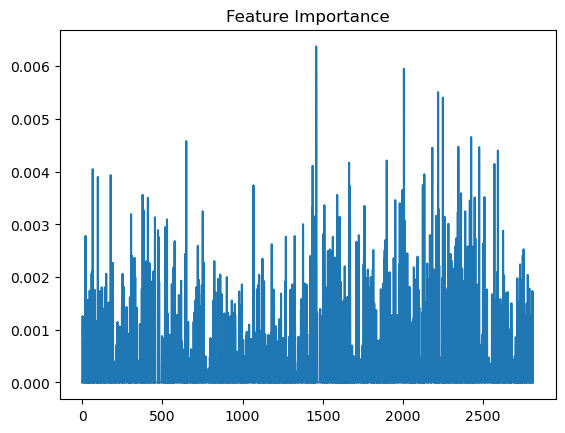

In [58]:
importances = model2.feature_importances_
plt.plot(importances)
plt.title("Feature Importance")
plt.show()

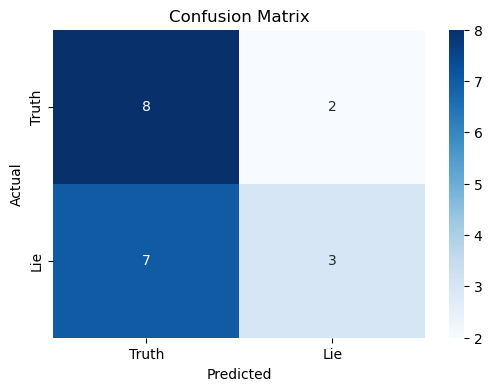

In [60]:
# Visualize the Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Lie'], yticklabels=['Truth', 'Lie'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------
### Step 4: Model Development 2:

In [62]:
# Configuration:
IMG_HEIGHT, IMG_WIDTH = 64, 64
CHANNELS = 3
TIME_STEPS = 10

TRAIN_DIR = os.path.join(proj_dir, "Train", "Train")
TEST_DIR = os.path.join(proj_dir, "Test", "Test")

# Helper functions:
def load_sequence_images(seq_path, time_steps=TIME_STEPS):
    frame_files = sorted([
        os.path.join(seq_path, f) for f in os.listdir(seq_path)
        if f.endswith(".png")
    ])[:time_steps]  # Limit sequence length

    frames = []
    for img_path in frame_files:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Re-size
        img = img.astype(np.float32) / 255.0  # Normalize
        frames.append(img)

    while len(frames) < time_steps:
        frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

    return np.array(frames)

def load_dataset(directories):
    X, y = [], []

    for data_dir in directories:
        for label_name in ["Truth", "Lie"]:
            label = 0 if label_name == "Truth" else 1
            label_path = os.path.join(data_dir, label_name)

            if not os.path.exists(label_path):
                continue

            for person in os.listdir(label_path):
                person_dir = os.path.join(label_path, person)
                for seq in os.listdir(person_dir):
                    seq_path = os.path.join(person_dir, seq)
                    if os.path.isdir(seq_path):
                        frames = load_sequence_images(seq_path)
                        X.append(frames)
                        y.append(label)

    return np.array(X), np.array(y)

X_data, y_data = load_dataset([TRAIN_DIR, TEST_DIR])

# Run and Check Shape
print(f"Combined Dataset Loaded")
print(f"X shape: {X_data.shape}")  # Expected: (samples, time_steps, height, width, channels)
print(f"y shape: {y_data.shape}")  # Expected: (samples,)

Combined Dataset Loaded
X shape: (96, 10, 64, 64, 3)
y shape: (96,)


In [64]:
# Load & Split the Data: 70% training, 15% validation, 15% testing

# load
X_all, y_all = load_dataset([TRAIN_DIR, TEST_DIR])

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, stratify=y_all, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Output shapes
print("Dataset ready:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val  : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

Dataset ready:
Train: (67, 10, 64, 64, 3), (67,)
Val  : (14, 10, 64, 64, 3), (14,)
Test : (15, 10, 64, 64, 3), (15,)


In [66]:
print(np.bincount(y_train))
print(np.bincount(y_val))
print(np.bincount(y_test))

[33 34]
[7 7]
[8 7]


In [68]:
# Correct class imbalance using class weighting

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0151515151515151, 1: 0.9852941176470589}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_66             │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_67             │ (None, 10, 62, 62, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_68             │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_69             │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_70             │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_71             │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 128)            │     6,455,808 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,475,457 (24.70 MB)

 Trainable params: 6,475,393 (24.70 MB)

 Non-trainable params: 64 (256.00 B)

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


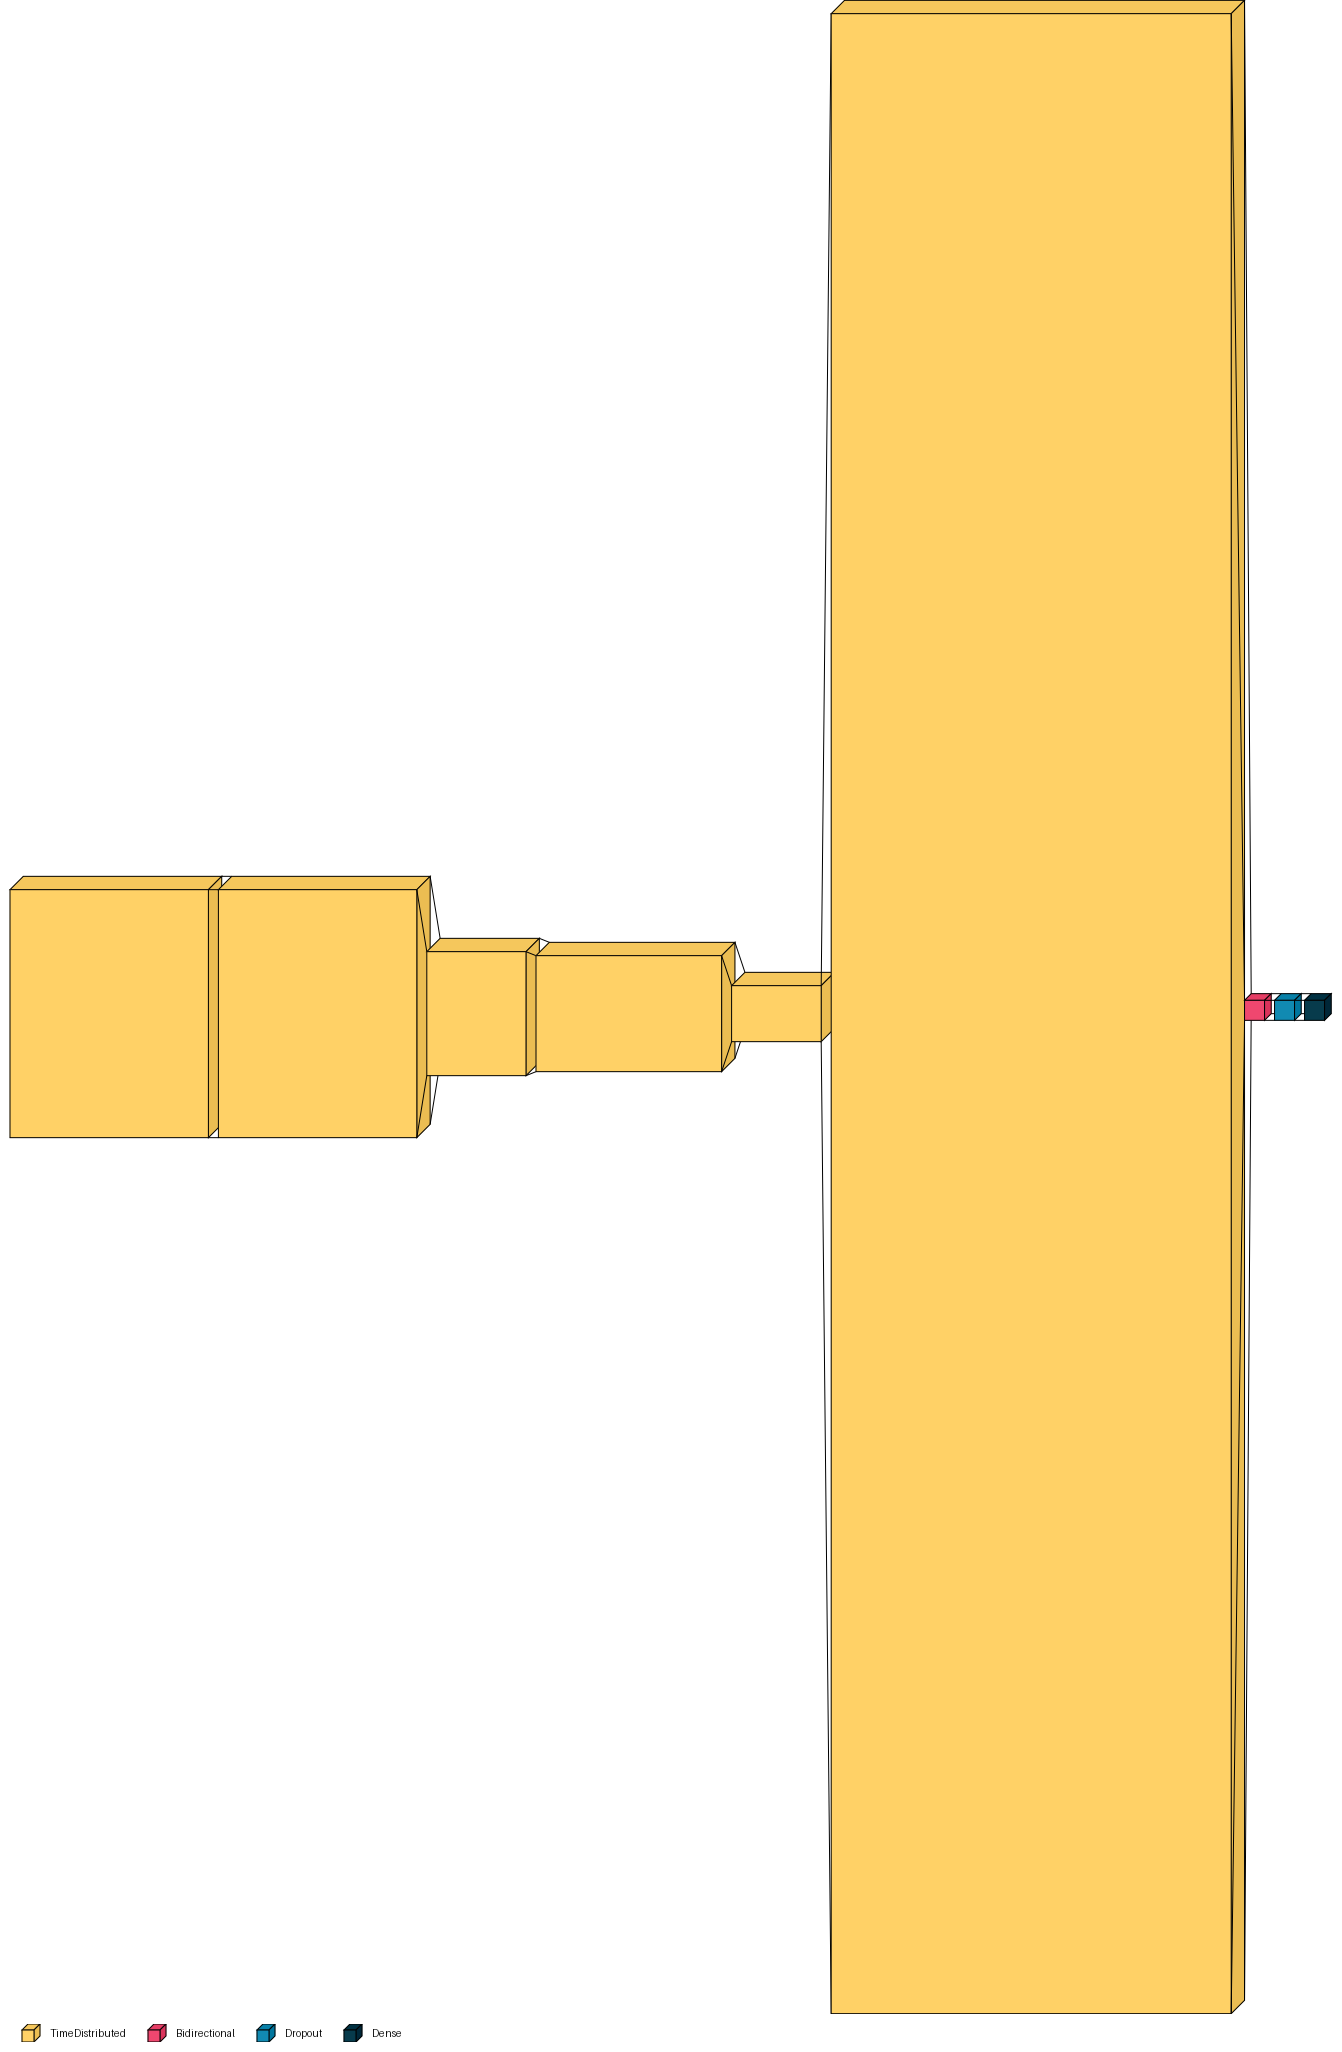

In [117]:
# CNN-LSTM Hybrid Model

from tensorflow.keras.layers import Input, BatchNormalization, Bidirectional

def build_model():
    model = Sequential([
        # Input layer added
        Input(shape=(TIME_STEPS, IMG_HEIGHT, IMG_WIDTH, CHANNELS)),  # Input layer added
        
        # CNN block applied to each frame (TimeDistributed)
        TimeDistributed(Conv2D(32, (3, 3), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        TimeDistributed(Flatten()),
        
        # LSTM for temporal modeling
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    model.summary()

    return model

model = build_model()
vk.layered_view(model,legend=True)

In [119]:
y_pred_probs = model.predict(X_test)
y_preds = (y_pred_probs > 0.5).astype(int)
print("Predicted classes:", y_preds.flatten())
print("Prediction probabilities (first 10):", y_pred_probs[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Predicted classes: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
Prediction probabilities (first 10): [[0.5223253 ]
 [0.51488745]
 [0.5055822 ]
 [0.5096834 ]
 [0.5222926 ]
 [0.49950284]
 [0.5137228 ]
 [0.5113821 ]
 [0.5162354 ]
 [0.53203905]]


In [121]:
preds = model.predict(X_test)
print("Min:", preds.min(), "Max:", preds.max(), "Mean:", preds.mean())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Min: 0.49950284 Max: 0.53203905 Mean: 0.5154028


In [127]:
# For confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0 8]
 [2 5]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      0.71      0.50         7

    accuracy                           0.33        15
   macro avg       0.19      0.36      0.25        15
weighted avg       0.18      0.33      0.23        15



In [131]:
# Callbacks to prevent overfitting

from keras.callbacks import EarlyStopping

def get_callbacks(patience=10, monitor='val_loss'):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,  # Wait for 10 epochs before stopping
        restore_best_weights=True
    )

    return [early_stopping] 
    
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=get_callbacks(),
    class_weight=class_weights_dict,  # based on imbalance
    verbose=2
)

Epoch 1/50
5/5 - 4s - 745ms/step - accuracy: 0.4627 - loss: 0.7286 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/50
5/5 - 4s - 719ms/step - accuracy: 0.5075 - loss: 0.7148 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/50
5/5 - 4s - 720ms/step - accuracy: 0.5224 - loss: 0.7341 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/50
5/5 - 4s - 720ms/step - accuracy: 0.5224 - loss: 0.7199 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/50
5/5 - 4s - 725ms/step - accuracy: 0.5373 - loss: 0.7086 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 6/50
5/5 - 4s - 720ms/step - accuracy: 0.4776 - loss: 0.7448 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/50
5/5 - 4s - 711ms/step - accuracy: 0.4776 - loss: 0.7089 - val_accuracy: 0.3571 - val_loss: 0.6995
Epoch 8/50
5/5 - 4s - 722ms/step - accuracy: 0.4478 - loss: 0.7626 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 9/50
5/5 - 4s - 723ms/step - accuracy: 0.4925 - loss: 0.7059 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 10/50
5/5 - 4

In [137]:
# Save the entire model to keras file
save_model(model, 'cnn_lstm_lie_detection_model.keras')
print("Model saved as cnn_lstm_lie_detection_model.keras")

Model saved as cnn_lstm_lie_detection_model.keras



### Step 5: Evaluation:

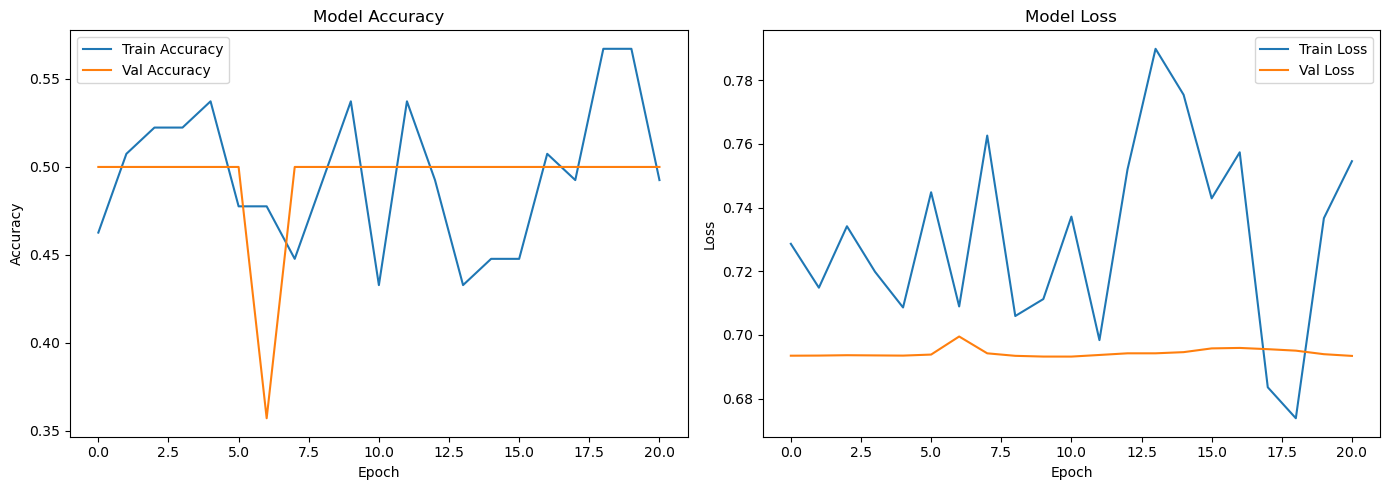


Evaluation on Training Set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step 
              precision    recall  f1-score   support

       Truth       0.60      0.18      0.28        33
         Lie       0.53      0.88      0.66        34

    accuracy                           0.54        67
   macro avg       0.56      0.53      0.47        67
weighted avg       0.56      0.54      0.47        67


Evaluation on Validation Set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
              precision    recall  f1-score   support

       Truth       0.50      0.14      0.22         7
         Lie       0.50      0.86      0.63         7

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.43        14
weighted avg       0.50      0.50      0.43        14


Evaluation on Test Set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
              precision    recall  f1-score   support

       Truth       0.00      0.00      0.00         8
         Lie       0.38      0.71    

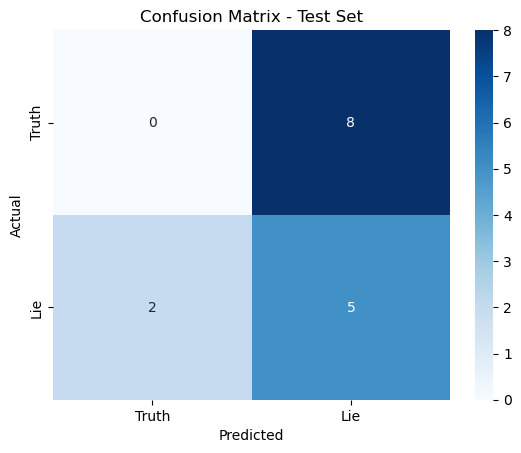

In [135]:
def evaluate_classification_network(model, X_train, y_train,
                                    X_val, y_val,
                                    X_test, y_test,
                                    history):
    # --- Plot training history ---
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Evaluation on Training Set ---
    print("\nEvaluation on Training Set:")
    train_preds = (model.predict(X_train) > 0.5).astype("int32")
    print(classification_report(y_train, train_preds, target_names=["Truth", "Lie"]))

    # --- Evaluation on Validation Set ---
    print("\nEvaluation on Validation Set:")
    val_preds = (model.predict(X_val) > 0.5).astype("int32")
    print(classification_report(y_val, val_preds, target_names=["Truth", "Lie"]))

    # --- Evaluation on Test Set ---
    print("\nEvaluation on Test Set:")
    test_preds = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, test_preds, target_names=["Truth", "Lie"]))

    # --- Confusion Matrix (Test Set) ---
    cm = confusion_matrix(y_test, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Truth", "Lie"], yticklabels=["Truth", "Lie"])
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# call the function
evaluate_classification_network(
    model,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    history
)

In [139]:
# Assess model performance using accuracy, precision, recall, and F1-score.
# Predict test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print metrics
print("Model Performance on Test Set:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Model Performance on Test Set:
Accuracy : 0.3333
Precision: 0.3846
Recall   : 0.7143
F1 Score : 0.5000


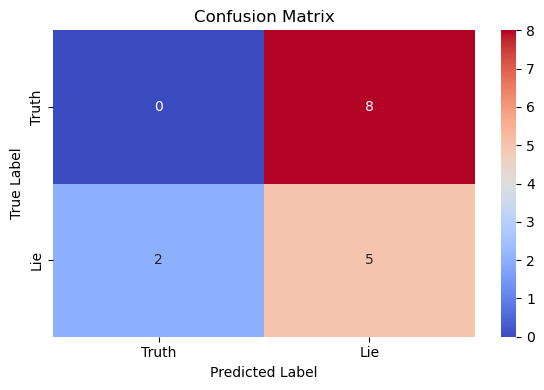

In [141]:
# Analyze confusion matrix to understand misclassifications.

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Truth', 'Lie'], yticklabels=['Truth', 'Lie'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# High TP and TN = model performing well.
# Low FN is critical — we want to catch lies.
# If FP is high, it means some truths are misclassified as lies (false accusations).

In [143]:
y_pred = (model.predict(X_test) > 0.5).astype("int32").ravel()

# Decode predictions and actuals
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [145]:
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         lie       0.00      0.00      0.00         8
       truth       0.38      0.71      0.50         7

    accuracy                           0.33        15
   macro avg       0.19      0.36      0.25        15
weighted avg       0.18      0.33      0.23        15



In [147]:
# Example: predict on a single sequence
sequence = X_test[0]  # Shape: (TIME_STEPS, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
sequence = np.expand_dims(sequence, axis=0)  # Add batch dimension

pred_prob = model.predict(sequence)
pred_label = int(pred_prob[0][0] > 0.5)

print("Predicted Label:", "Lie" if pred_label == 1 else "Truth")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Label: Lie


In [149]:
import joblib

# Save to file
joblib.dump(label_encoder, "label_encoder.joblib")
print("Label encoder saved successfully.")

Label encoder saved successfully.


### Step 6.1: XGBoost (Optical Flow + Temporal Landmarks)

In [179]:
# Combine Feature Sets

import xgboost as xgb
# Concatenate Optical Flow + Temporal Landmarks
X_combined = np.concatenate((X_flow, X_temporal), axis=1)
y_combined = y_flow  # Same labels as both come from same sequences

# Train-Test Split = Train:70% Validation:15% Test:15%
X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y_combined, test_size=0.3, stratify=y_combined, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Output shapes
print("Dataset ready:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val  : {X_val.shape}, {y_val.shape}")
print(f"Test : {X_test.shape}, {y_test.shape}")

Dataset ready:
Train: (67, 2812), (67,)
Val  : (14, 2812), (14,)
Test : (15, 2812), (15,)


In [181]:
print("Class distribution in y_train:", np.bincount(y_train))

Class distribution in y_train: [33 34]


In [183]:
# Ensure data splitting preserves class balance
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_val:", np.unique(y_val))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1]
Unique classes in y_val: [0 1]
Unique classes in y_test: [0 1]


In [191]:
# Correct class imbalance 
# Calculate scale_pos_weight
y_train_np = np.array(y_train, dtype=int)
neg, pos = np.bincount(y_train_np)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# Train XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Train the model
xgb_model.fit(
    X_train, y_train, 
    verbose=True
)

# Evaluate the Model
def evaluate_model(model, X, y, name):
    preds = model.predict(X)
    print(f"--- Evaluation on {name} ---")
    print(classification_report(y, preds, target_names=["Truth", "Lie"]))
    print(f"Accuracy: {accuracy_score(y, preds):.2f}\n")

evaluate_model(xgb_model, X_train, y_train, "Training Set")
evaluate_model(xgb_model, X_val, y_val, "Validation Set")
evaluate_model(xgb_model, X_test, y_test, "Test Set")

scale_pos_weight: 0.9705882352941176
--- Evaluation on Training Set ---
              precision    recall  f1-score   support

       Truth       1.00      1.00      1.00        33
         Lie       1.00      1.00      1.00        34

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Accuracy: 1.00

--- Evaluation on Validation Set ---
              precision    recall  f1-score   support

       Truth       1.00      0.71      0.83         7
         Lie       0.78      1.00      0.88         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Accuracy: 0.86

--- Evaluation on Test Set ---
              precision    recall  f1-score   support

       Truth       0.38      0.38      0.38         8
         Lie       0.29      0.29      0.29         7

    accura

In [193]:
# Save the Model
joblib.dump(xgb_model, "xgboost_lie_detector_model.pkl")
print("Model saved as xgboost_lie_detector.pkl")

Model saved as xgboost_lie_detector.pkl


### Step 6.2: Evaluation

In [195]:
# Evaluate on Test Set
# Predictions and probabilities
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability for class "1" (Lie)

# Summary Report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=["Truth", "Lie"]))

Classification Report (Test Set):
              precision    recall  f1-score   support

       Truth       0.38      0.38      0.38         8
         Lie       0.29      0.29      0.29         7

    accuracy                           0.33        15
   macro avg       0.33      0.33      0.33        15
weighted avg       0.33      0.33      0.33        15



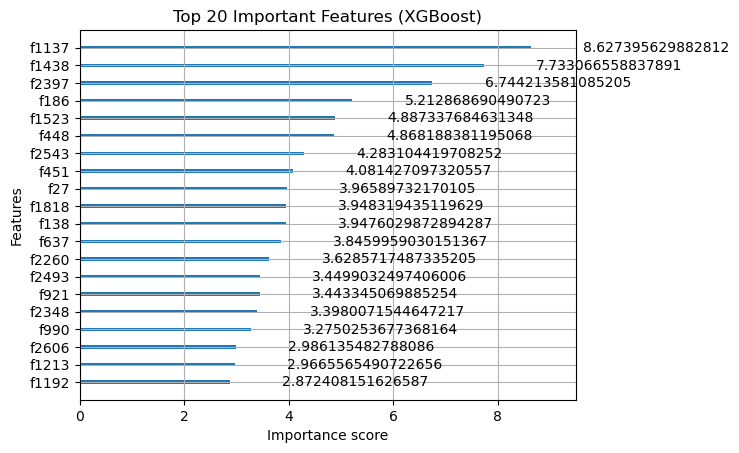

In [199]:
# Feature Importance Visualization
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (XGBoost)")
plt.show()

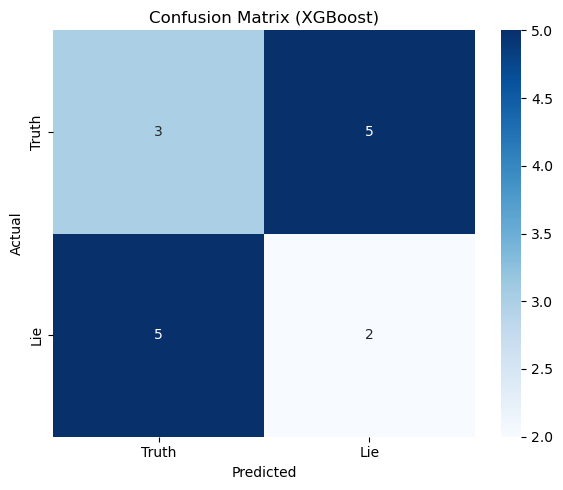

In [201]:
# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Truth", "Lie"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()

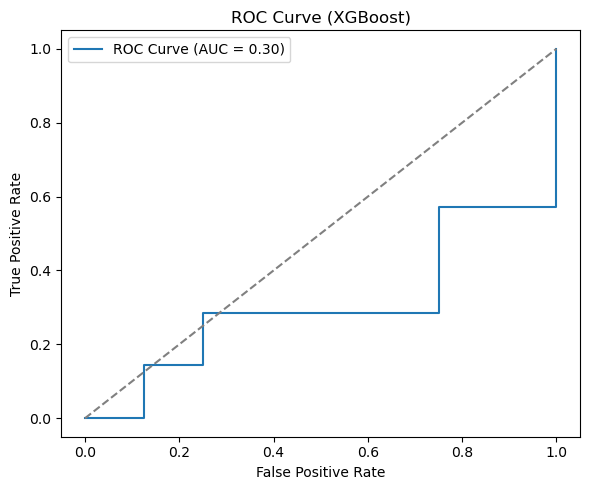

In [203]:
# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

In [209]:
%pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


IndexError: list index out of range

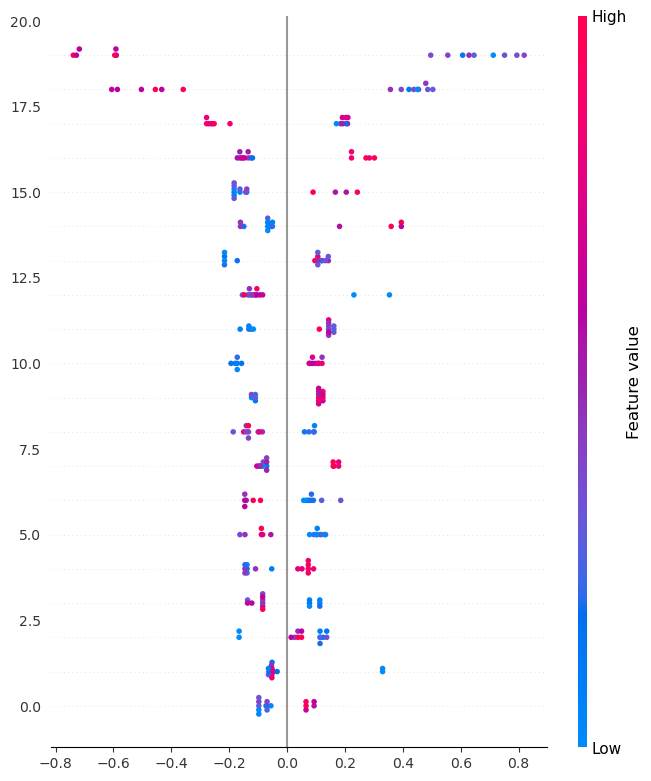

In [211]:
# SHAP Values for XGBoost (Interpretability)
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=[...])